In [15]:
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
%matplotlib inline  

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['^GSPC']#,'XSP.TO']


# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2017-10-13'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)


close = close.dropna()
close.head(10)

C:\Users\xexx\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,^GSPC
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980
2010-01-11,1146.979980
2010-01-12,1136.219971
2010-01-13,1145.680054
2010-01-14,1148.459961
2010-01-15,1136.030029


In [7]:
sp500 = close.copy()


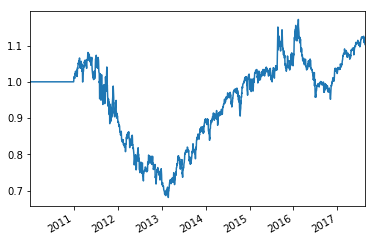

In [16]:
sp500['42d'] = np.round(sp500['^GSPC'].rolling(window=42).mean(),2)
sp500['252d'] = np.round(sp500['^GSPC'].rolling(window=252).mean(),2)
 
#create column with moving average spread differential
sp500['42-252'] = sp500['42d'] - sp500['252d']
 
#set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
X = 50
sp500['Stance'] = np.where(sp500['42-252'] > X, 1, 0)
sp500['Stance'] = np.where(sp500['42-252'] < X, -1, sp500['Stance'])
sp500['Stance'].value_counts()
 
#create columns containing daily market log returns and strategy daily log returns
sp500['Market Returns'] = np.log(sp500['^GSPC'] / sp500['^GSPC'].shift(1))
sp500['Strategy'] = sp500['Market Returns'] * sp500['Stance'].shift(1)
 
#set strategy starting equity to 1 (i.e. 100%) and generate equity curve
sp500['Strategy Equity'] = sp500['Strategy'].cumsum() + 1
 
#show chart of equity curve
sp500['Strategy Equity'].plot()

In [17]:
strat = pd.DataFrame([sp500['Strategy Equity'], sp500['Strategy']]).transpose()

In [25]:
#create columns that signifies whether each days return was positive, negative or flat.
strat['win'] = (np.where(strat['Strategy'] > 0, 1,0)) 
strat['loss'] = (np.where(strat['Strategy'] < 0, 1,0)) 
strat['scratch'] = (np.where(strat['Strategy'] == 0, 1,0))
strat['losscum'] = (np.where(strat['Strategy'] < 0, 1,0)).cumsum() 
strat['scratchcum'] = (np.where(strat['Strategy'] == 0, 1,0)).cumsum() #create a columns that holds a running sum of trading days - we will use this to create our percentages later strat['days'] = (strat['wincum'] + strat['losscum'] + strat['scratchcum']) #create columns that shows the 252 day rolling sum of the winning/losing/flat days strat['rollwin'] = strat['win'].rolling(window=252).sum() strat['rollloss'] = strat['loss'].rolling(window=252).sum() strat['rollscratch'] = strat['scratch'].rolling(window=252).sum() #create columns with hit ratio and loss ratio data strat['hitratio'] = strat['wincum'] / (strat['wincum']+strat['losscum']) strat['lossratio'] = 1 - strat['hitratio'] ##create columns with rolling 252 day hit ratio and loss ratio data strat['rollhitratio'] = strat['hitratio'].rolling(window=252).mean() strat['rolllossratio'] =1 - strat['rollhitratio'] #create column with rolling 12 month return strat['roll12mret'] = strat['Strategy'].rolling(window=252).sum() #create column with average win, average loss and average daily return data strat['averagewin'] = strat['Strategy'][(strat['Strategy'] > 0)].mean() 
strat['averageloss'] = strat['Strategy'][(strat['Strategy'] < 0)].mean() 
strat['averagedailyret'] = strat['Strategy'].mean() 
 
#create column with rolling 1 year daily standard deviation and rolling 1 year annualised standard deviation
strat['roll12mstdev'] = strat['Strategy'].rolling(window=252).std() 
strat['roll12mannualisedvol'] = strat['roll12mstdev'] * sqrt(252)

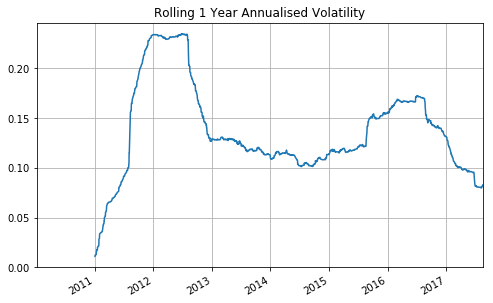

In [26]:
strat['roll12mannualisedvol'].plot(grid=True, figsize=(8,5),title='Rolling 1 Year Annualised Volatility')

In [30]:
strat

,Strategy Equity,Strategy,win,loss,scratch,losscum,scratchcum,averageloss,averagedailyret,roll12mstdev,roll12mannualisedvol
2010-01-04,NaN,NaN,0,0,0,0,0,-0.00645,0.000054,NaN,NaN
2010-01-05,1.000000,0.000000,0,0,1,0,1,-0.00645,0.000054,NaN,NaN
2010-01-06,1.000000,0.000000,0,0,1,0,2,-0.00645,0.000054,NaN,NaN
2010-01-07,1.000000,0.000000,0,0,1,0,3,-0.00645,0.000054,NaN,NaN
2010-01-08,1.000000,0.000000,0,0,1,0,4,-0.00645,0.000054,NaN,NaN
2010-01-11,1.000000,0.000000,0,0,1,0,5,-0.00645,0.000054,NaN,NaN
2010-01-12,1.000000,-0.000000,0,0,1,0,6,-0.00645,0.000054,NaN,NaN
2010-01-13,1.000000,0.000000,0,0,1,0,7,-0.00645,0.000054,NaN,NaN
2010-01-14,1.000000,0.000000,0,0,1,0,8,-0.00645,0.000054,NaN,NaN
2010-01-15,1.000000,-0.000000,0,0,1,0,9,-0.00645,0.000054,NaN,NaN
